In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import joblib
import re
import os
from wordcloud import WordCloud

print("🤖 Starting TF-IDF Model Development...")



🤖 Starting TF-IDF Model Development...


In [2]:
#Load Cleaned Data

print("📊 Loading cleaned data from Member 1...")

try:
    train_df = pd.read_csv('../data/train_clean.csv')
    test_df = pd.read_csv('../data/test_clean.csv')
    valid_df = pd.read_csv('../data/valid_clean.csv')
    
    print("✅ Data loaded successfully!")
    print(f"Training: {len(train_df)} samples")
    print(f"Test: {len(test_df)} samples")
    print(f"Validation: {len(valid_df)} samples")
    
except FileNotFoundError:
    print("❌ Cleaned data not found!")
    print("Please run Member 1's notebook first (01_data_cleaning.ipynb)")
    exit()

# Check data quality
print(f"\n🔍 Data Quality Check:")
print(f"Train - Real: {sum(train_df['label_binary'] == 1)}, Fake: {sum(train_df['label_binary'] == 0)}")
print(f"Test - Real: {sum(test_df['label_binary'] == 1)}, Fake: {sum(test_df['label_binary'] == 0)}")



📊 Loading cleaned data from Member 1...
✅ Data loaded successfully!
Training: 10240 samples
Test: 1267 samples
Validation: 1284 samples

🔍 Data Quality Check:
Train - Real: 5752, Fake: 4488
Test - Real: 714, Fake: 553



📝 TEXT ANALYSIS...


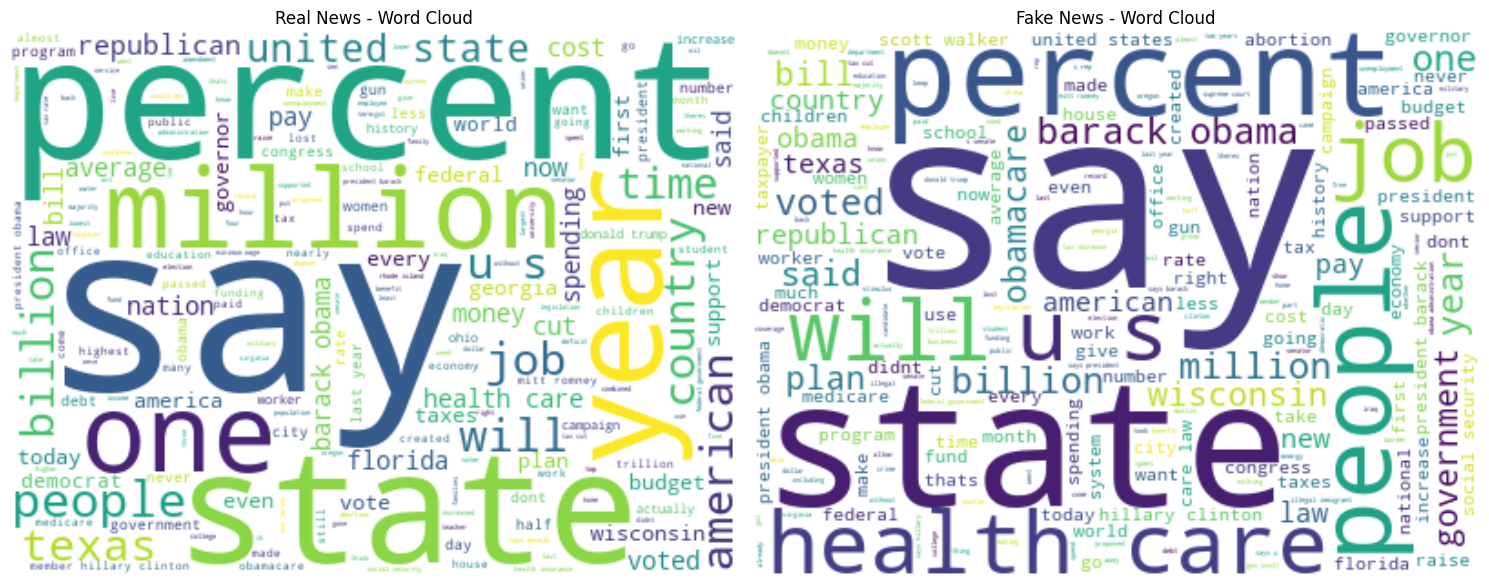

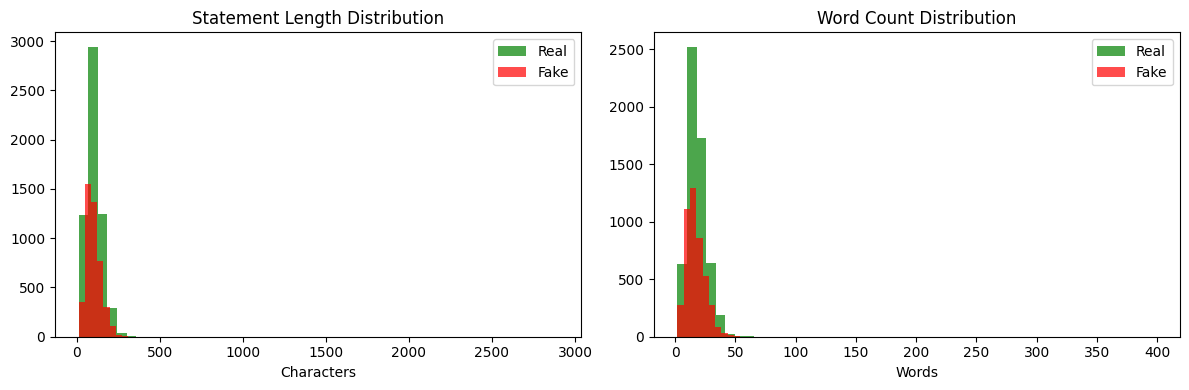

In [3]:
#Text Analysis and Visualization
print("\n📝 TEXT ANALYSIS...")

# Separate real vs fake news text
real_news = train_df[train_df['label_binary'] == 1]['clean_statement']
fake_news = train_df[train_df['label_binary'] == 0]['clean_statement']

# Create word clouds
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
real_text = ' '.join(real_news.astype(str))
wordcloud_real = WordCloud(width=400, height=300, background_color='white').generate(real_text)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.title('Real News - Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
fake_text = ' '.join(fake_news.astype(str))
wordcloud_fake = WordCloud(width=400, height=300, background_color='white').generate(fake_text)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Fake News - Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

# Text length analysis
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(real_news.str.len(), bins=50, alpha=0.7, label='Real', color='green')
plt.hist(fake_news.str.len(), bins=50, alpha=0.7, label='Fake', color='red')
plt.title('Statement Length Distribution')
plt.xlabel('Characters')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(real_news.str.split().str.len(), bins=50, alpha=0.7, label='Real', color='green')
plt.hist(fake_news.str.split().str.len(), bins=50, alpha=0.7, label='Fake', color='red')
plt.title('Word Count Distribution')
plt.xlabel('Words')
plt.legend()

plt.tight_layout()
plt.show()




In [4]:
#TF-IDF Feature Extraction
print("\n🔤 CREATING TF-IDF FEATURES...")

# Initialize TF-IDF vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,          # Top 5000 most important words
    stop_words='english',       # Remove common English words
    ngram_range=(1, 2),         # Use single words and bigrams
    min_df=2,                   # Word must appear at least 2 times
    max_df=0.95,                # Ignore words that appear in >95% of documents
    lowercase=True,             # Convert to lowercase
    strip_accents='ascii'       # Remove accents
)

# Fit on training data and transform all datasets
print("  🔄 Fitting TF-IDF on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_df['clean_statement'])
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_statement'])
X_valid_tfidf = tfidf_vectorizer.transform(valid_df['clean_statement'])

# Get target variables
y_train = train_df['label_binary']
y_test = test_df['label_binary']
y_valid = valid_df['label_binary']

print(f"✅ TF-IDF Features Created:")
print(f"   Feature dimensions: {X_train_tfidf.shape[1]}")
print(f"   Training samples: {X_train_tfidf.shape[0]}")
print(f"   Test samples: {X_test_tfidf.shape[0]}")



🔤 CREATING TF-IDF FEATURES...
  🔄 Fitting TF-IDF on training data...
✅ TF-IDF Features Created:
   Feature dimensions: 5000
   Training samples: 10240
   Test samples: 1267


In [5]:
#Train Multiple Models
print("\n🎯 TRAINING TF-IDF MODELS...")

models = {}
results = {}

# Model 1: Logistic Regression
print("\n🔹 Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_tfidf)
lr_test_pred = lr_model.predict(X_test_tfidf)

# Store results
models['logistic_regression'] = lr_model
results['logistic_regression'] = {
    'train_accuracy': accuracy_score(y_train, lr_train_pred),
    'test_accuracy': accuracy_score(y_test, lr_test_pred),
    'predictions': lr_test_pred
}

print(f"  ✅ Logistic Regression - Test Accuracy: {results['logistic_regression']['test_accuracy']:.3f}")

# Model 2: Random Forest
print("\n🌲 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
# Predictions
rf_train_pred = rf_model.predict(X_train_tfidf)
rf_test_pred = rf_model.predict(X_test_tfidf)

# Store results
models['random_forest'] = rf_model
results['random_forest'] = {
    'train_accuracy': accuracy_score(y_train, rf_train_pred),
    'test_accuracy': accuracy_score(y_test, rf_test_pred),
    'predictions': rf_test_pred
}

print(f"  ✅ Random Forest - Test Accuracy: {results['random_forest']['test_accuracy']:.3f}")





🎯 TRAINING TF-IDF MODELS...

🔹 Training Logistic Regression...
  ✅ Logistic Regression - Test Accuracy: 0.612

🌲 Training Random Forest...
  ✅ Random Forest - Test Accuracy: 0.597



📊 MODEL EVALUATION...

🏆 Model Performance Comparison:
                 Model Train Accuracy Test Accuracy Overfitting
0  Logistic Regression          0.760         0.612       0.148
1        Random Forest          0.999         0.597       0.402


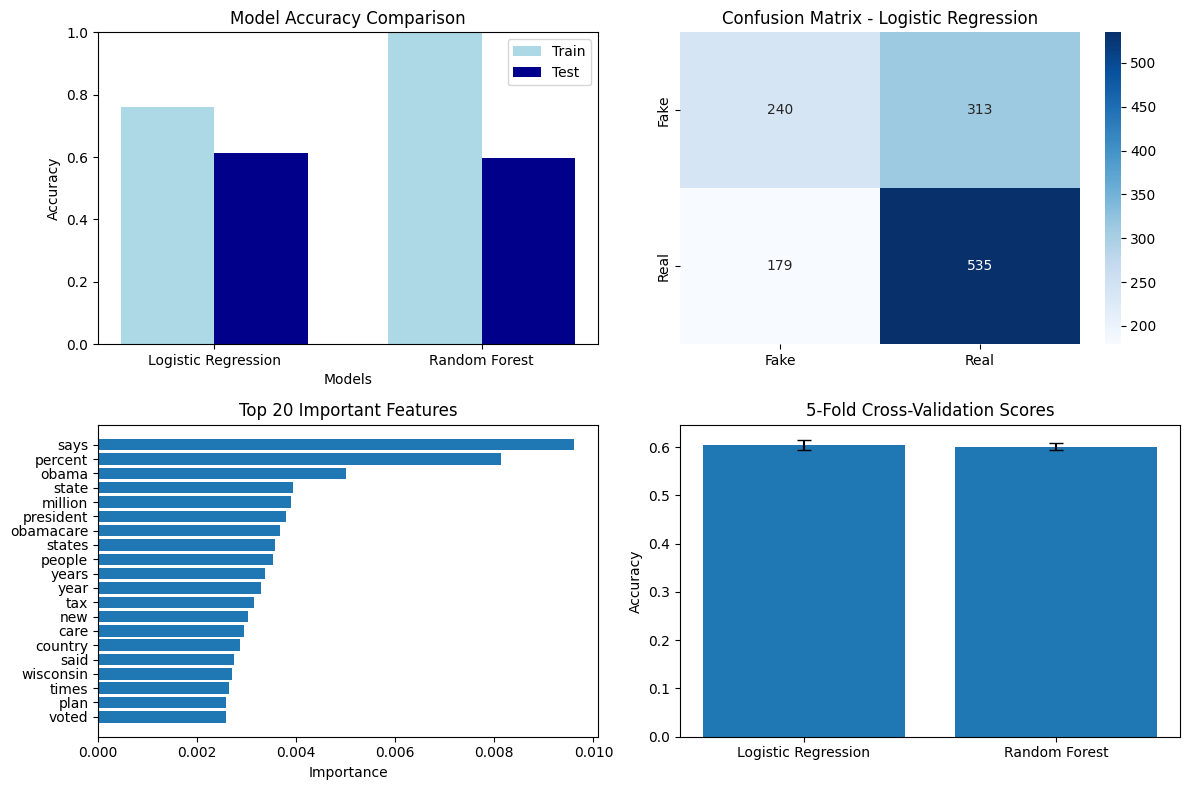

In [6]:
#Model Evaluation and Comparison
print("\n📊 MODEL EVALUATION...")

# Create results comparison
comparison_data = []
for model_name, model_results in results.items():
    comparison_data.append({
        'Model': model_name.replace('_', ' ').title(),
        'Train Accuracy': f"{model_results['train_accuracy']:.3f}",
        'Test Accuracy': f"{model_results['test_accuracy']:.3f}",
        'Overfitting': f"{model_results['train_accuracy'] - model_results['test_accuracy']:.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n🏆 Model Performance Comparison:")
print(comparison_df)

# Visualize results
plt.figure(figsize=(12, 8))

# Accuracy comparison
plt.subplot(2, 2, 1)
model_names = [name.replace('_', ' ').title() for name in results.keys()]
train_accs = [results[name]['train_accuracy'] for name in results.keys()]
test_accs = [results[name]['test_accuracy'] for name in results.keys()]

x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, train_accs, width, label='Train', color='lightblue')
plt.bar(x + width/2, test_accs, width, label='Test', color='darkblue')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.ylim(0, 1)

# Best model confusion matrix
best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_predictions = results[best_model_name]['predictions']

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Confusion Matrix - {best_model_name.replace("_", " ").title()}')

# Feature importance (for Random Forest)
if 'random_forest' in models:
    plt.subplot(2, 2, 3)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    importances = models['random_forest'].feature_importances_
    
    # Get top 20 features
    top_indices = importances.argsort()[-20:]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]
    plt.barh(range(len(top_features)), top_importances)
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Top 20 Important Features')
    plt.xlabel('Importance')

# Cross-validation scores
plt.subplot(2, 2, 4)
cv_scores = {}
for model_name, model in models.items():
    cv_scores[model_name] = cross_val_score(model, X_train_tfidf, y_train, cv=5)

cv_means = [np.mean(cv_scores[name]) for name in cv_scores.keys()]
cv_stds = [np.std(cv_scores[name]) for name in cv_scores.keys()]

plt.bar(range(len(cv_means)), cv_means, yerr=cv_stds, capsize=5)
plt.xticks(range(len(cv_means)), [name.replace('_', ' ').title() for name in cv_scores.keys()])
plt.title('5-Fold Cross-Validation Scores')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()



In [7]:
#Detailed Classification Report
print("\n📈 DETAILED CLASSIFICATION REPORTS...")

for model_name, model_results in results.items():
    print(f"\n📊 {model_name.replace('_', ' ').title()} Classification Report:")
    print("="*60)
    print(classification_report(y_test, model_results['predictions'], 
                              target_names=['Fake', 'Real']))



📈 DETAILED CLASSIFICATION REPORTS...

📊 Logistic Regression Classification Report:
              precision    recall  f1-score   support

        Fake       0.57      0.43      0.49       553
        Real       0.63      0.75      0.69       714

    accuracy                           0.61      1267
   macro avg       0.60      0.59      0.59      1267
weighted avg       0.61      0.61      0.60      1267


📊 Random Forest Classification Report:
              precision    recall  f1-score   support

        Fake       0.55      0.42      0.48       553
        Real       0.62      0.73      0.67       714

    accuracy                           0.60      1267
   macro avg       0.59      0.58      0.58      1267
weighted avg       0.59      0.60      0.59      1267



In [8]:
#Save Best Model
print("\n💾 SAVING MODELS...")

# Determine best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = models[best_model_name]

print(f"🏆 Best model: {best_model_name.replace('_', ' ').title()}")
print(f"   Test Accuracy: {results[best_model_name]['test_accuracy']:.3f}")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the best TF-IDF model and vectorizer
joblib.dump(best_model, '../models/tfidf_model.pkl')
joblib.dump(tfidf_vectorizer, '../models/tfidf_vectorizer.pkl')

# Save all models for comparison
for model_name, model in models.items():
    joblib.dump(model, f'../models/tfidf_{model_name}.pkl')

print("✅ Models saved successfully!")
print("📁 Files created:")
print("   - ../models/tfidf_model.pkl (best model)")
print("   - ../models/tfidf_vectorizer.pkl")
print(f"   - ../models/tfidf_logistic_regression.pkl")
print(f"   - ../models/tfidf_random_forest.pkl")



💾 SAVING MODELS...
🏆 Best model: Logistic Regression
   Test Accuracy: 0.612
✅ Models saved successfully!
📁 Files created:
   - ../models/tfidf_model.pkl (best model)
   - ../models/tfidf_vectorizer.pkl
   - ../models/tfidf_logistic_regression.pkl
   - ../models/tfidf_random_forest.pkl


In [9]:
#Model Testing Function
print("\n🧪 CREATING MODEL TESTING FUNCTION...")

def test_fake_news_prediction(text_input, model=None, vectorizer=None):
    """
    Test the model with custom input
    """
    if model is None:
        model = best_model
    if vectorizer is None:
        vectorizer = tfidf_vectorizer
    
    # Clean the input text (same as Member 1's cleaning function)
    cleaned_text = re.sub(r'http\S+', '', text_input.lower())
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    # Transform to TF-IDF features
    text_features = vectorizer.transform([cleaned_text])
    
    # Make prediction
    prediction = model.predict(text_features)[0]
    probability = model.predict_proba(text_features)[0]
    
    return {
        'prediction': 'Real' if prediction == 1 else 'Fake',
        'confidence': max(probability),
        'probabilities': {'Fake': probability[0], 'Real': probability[1]}
    }
# Test with sample statements
test_statements = [
    "The President announced new economic policies today.",
    "Scientists have discovered that eating chocolate cures cancer completely.",
    "The stock market closed higher today following positive economic reports.",
    "Aliens have officially landed and are meeting with world leaders."
]

print("\n🧪 TESTING MODEL WITH SAMPLE STATEMENTS:")
print("="*70)

for i, statement in enumerate(test_statements, 1):
    result = test_fake_news_prediction(statement)
    print(f"\n📰 Test {i}:")
    print(f"   Statement: {statement}")
    print(f"   Prediction: {result['prediction']}")
    print(f"   Confidence: {result['confidence']:.3f}")
    print(f"   Real probability: {result['probabilities']['Real']:.3f}")
    print(f"   Fake probability: {result['probabilities']['Fake']:.3f}")




🧪 CREATING MODEL TESTING FUNCTION...

🧪 TESTING MODEL WITH SAMPLE STATEMENTS:

📰 Test 1:
   Statement: The President announced new economic policies today.
   Prediction: Fake
   Confidence: 0.594
   Real probability: 0.406
   Fake probability: 0.594

📰 Test 2:
   Statement: Scientists have discovered that eating chocolate cures cancer completely.
   Prediction: Fake
   Confidence: 0.606
   Real probability: 0.394
   Fake probability: 0.606

📰 Test 3:
   Statement: The stock market closed higher today following positive economic reports.
   Prediction: Real
   Confidence: 0.560
   Real probability: 0.560
   Fake probability: 0.440

📰 Test 4:
   Statement: Aliens have officially landed and are meeting with world leaders.
   Prediction: Real
   Confidence: 0.516
   Real probability: 0.516
   Fake probability: 0.484


In [10]:
#Feature Analysis
print("\n🔍 ANALYZING IMPORTANT FEATURES...")

import re

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Analyze Logistic Regression coefficients
if 'logistic_regression' in models:
    lr_coef = models['logistic_regression'].coef_[0]
    
    # Most indicative of REAL news (positive coefficients)
    real_indices = lr_coef.argsort()[-20:]
    real_features = [(feature_names[i], lr_coef[i]) for i in real_indices]
    
    # Most indicative of FAKE news (negative coefficients)  
    fake_indices = lr_coef.argsort()[:20]
    fake_features = [(feature_names[i], lr_coef[i]) for i in fake_indices]
    
    print("\n🟢 TOP 10 WORDS INDICATING REAL NEWS:")
    for word, coef in real_features[-10:]:
        print(f"   {word}: {coef:.3f}")
    
    print("\n🔴 TOP 10 WORDS INDICATING FAKE NEWS:")
    for word, coef in fake_features[:10]:
        print(f"   {word}: {coef:.3f}")



🔍 ANALYZING IMPORTANT FEATURES...

🟢 TOP 10 WORDS INDICATING REAL NEWS:
   terms: 1.440
   says scott: 1.463
   debt: 1.625
   months: 1.657
   times: 1.689
   average: 1.729
   georgia: 1.845
   day: 1.992
   countries: 2.161
   percent: 2.166

🔴 TOP 10 WORDS INDICATING FAKE NEWS:
   rep: -1.622
   obama: -1.583
   obamacare: -1.567
   illegals: -1.558
   wisconsin: -1.540
   muslim: -1.350
   away: -1.345
   team: -1.302
   seven years: -1.294
   nuclear weapons: -1.287


In [14]:
#Cross-Validation Analysis
print("\n🔄 CROSS-VALIDATION ANALYSIS...")

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

# Perform detailed cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = {}
for model_name, model in models.items():
    print(f"\n📊 Cross-validating {model_name}...")
    
    cv_accuracies = []
    cv_precisions = []
    cv_recalls = []
    cv_f1s = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_tfidf, y_train)):
        X_fold_train, X_fold_val = X_train_tfidf[train_idx], X_train_tfidf[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Train on fold
        model.fit(X_fold_train, y_fold_train)
        fold_pred = model.predict(X_fold_val)
        
        # Calculate metrics
        fold_acc = accuracy_score(y_fold_val, fold_pred)
        fold_precision, fold_recall, fold_f1, _ = precision_recall_fscore_support(
            y_fold_val, fold_pred, average='weighted'
        )
    cv_accuracies.append(fold_acc)
    cv_precisions.append(fold_precision)
    cv_recalls.append(fold_recall)
    cv_f1s.append(fold_f1)
    
    cv_results[model_name] = {
        'accuracy': cv_accuracies,
        'precision': cv_precisions,
        'recall': cv_recalls,
        'f1': cv_f1s
    }
    
    print(f"  ✅ {model_name} CV Accuracy: {np.mean(cv_accuracies):.3f} ± {np.std(cv_accuracies):.3f}")



🔄 CROSS-VALIDATION ANALYSIS...

📊 Cross-validating logistic_regression...
  ✅ logistic_regression CV Accuracy: 0.631 ± 0.000

📊 Cross-validating random_forest...
  ✅ random_forest CV Accuracy: 0.618 ± 0.000


In [17]:
#Save Results and Documentation
print("\n📄 SAVING RESULTS AND DOCUMENTATION...")

# Create results summary
results_summary = {
    'Model': [],
    'Test_Accuracy': [],
    'CV_Accuracy_Mean': [],
    'CV_Accuracy_Std': [],
    'Train_Accuracy': []
}

for model_name in results.keys():
    results_summary['Model'].append(model_name.replace('_', ' ').title())
    results_summary['Test_Accuracy'].append(f"{results[model_name]['test_accuracy']:.3f}")
    results_summary['CV_Accuracy_Mean'].append(f"{np.mean(cv_results[model_name]['accuracy']):.3f}")
    results_summary['CV_Accuracy_Std'].append(f"{np.std(cv_results[model_name]['accuracy']):.3f}")
    results_summary['Train_Accuracy'].append(f"{results[model_name]['train_accuracy']:.3f}")

results_df = pd.DataFrame(results_summary)
results_df.to_csv('../models/tfidf_model_results.csv', index=False)

# Save feature importance (if Random Forest)
if 'random_forest' in models:
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': models['random_forest'].feature_importances_
    }).sort_values('importance', ascending=False)
    feature_importance_df.to_csv('../models/tfidf_feature_importance.csv', index=False)
    print("✅ Feature importance saved to tfidf_feature_importance.csv")

print("\n🎉 TF-IDF MODEL DEVELOPMENT COMPLETE!")
print("📁 Files created for team:")
print("   - ../models/tfidf_model.pkl (best model)")
print("   - ../models/tfidf_vectorizer.pkl")
print("   - ../models/tfidf_model_results.csv")
print("   - ../models/tfidf_feature_importance.csv")
print("\n👥 Next: Member 3 can now develop BERT model (03_bert_model.ipynb)")
print("💡 Member 4 can use these TF-IDF features for the hybrid model!")




📄 SAVING RESULTS AND DOCUMENTATION...
✅ Feature importance saved to tfidf_feature_importance.csv

🎉 TF-IDF MODEL DEVELOPMENT COMPLETE!
📁 Files created for team:
   - ../models/tfidf_model.pkl (best model)
   - ../models/tfidf_vectorizer.pkl
   - ../models/tfidf_model_results.csv
   - ../models/tfidf_feature_importance.csv

👥 Next: Member 3 can now develop BERT model (03_bert_model.ipynb)
💡 Member 4 can use these TF-IDF features for the hybrid model!


In [ ]:
#Quick Demo Function
print("\n🎬 DEMO FUNCTION FOR TEAM TESTING:")

def demo_tfidf_model():
    """
    Quick demo function for team testing
    """
    print("🎯 TF-IDF Model Demo")
    print("="*30)
    
    sample_news = [
        "Breaking: New vaccine shows 95% effectiveness in clinical trials",
        "SHOCKING: Scientists prove that water is actually dangerous!",
        "Economic report shows steady growth in manufacturing sector",
        "Celebrities secretly control the world through hidden messages"
    ]
    
    for news in sample_news:
        result = test_fake_news_prediction(news)
        print(f"\n📰 {news[:50]}...")
        print(f"   🤖 Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")

# Run demo
demo_tfidf_model()